In [286]:
import os
import glob
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2
import ipyplot

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy

# LOAD

In [246]:
DATASET_FOLDER = 'data'

In [247]:
def load_dataset(dataset):
    data = np.load(f'{DATASET_FOLDER}/{dataset}.npz')
    imgs = data['imgs'].astype(np.float32)/255
    imgs = np.expand_dims(imgs, axis=-1)
    
    df = pd.read_csv(f'{DATASET_FOLDER}/{dataset}.csv')
    names = [name.replace('.png', '') for name in data['names']]
    assert (df.name == names).all()
    if 'label' in df.columns:
        labels = df.label.values
    else:
        labels = None
    
    return imgs, labels, names

In [248]:
train_imgs, train_labels, train_names = load_dataset('train')
test_imgs, test_labels, test_names = load_dataset('test')

In [249]:
# ipyplot.plot_class_tabs(train_imgs[..., 0], train_labels)
# ipyplot.plot_images(test_imgs[..., 0])

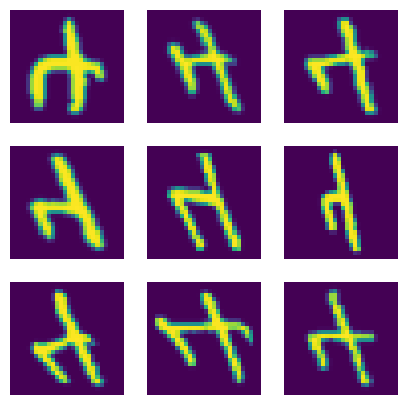

In [250]:
number_to_transform = 4

plt.figure(figsize=(5, 5))
for i in range(9):
    # flip the image vertically
    image = cv2.flip(train_imgs[train_labels == number_to_transform][i], 0)
    cv2.imshow("image", image[0])
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis("off");
# print(image[0].shape)

In [251]:
numbers_to_flip = [4,7]

number_images_augmented = 0
for i in numbers_to_flip:
    number_images_augmented += np.sum(train_labels == i)
train_imgs_augmented = np.empty((number_images_augmented,)+(28,28,1))
train_labels_augmented = np.empty((number_images_augmented,))
train_labels_augmented.fill(10)

In [252]:
print(train_imgs.shape)
print(train_labels.shape)
print(train_imgs_augmented.shape)
print(train_labels_augmented.shape)

(60000, 28, 28, 1)
(60000,)
(12000, 28, 28, 1)
(12000,)


In [253]:
position = 0
for i in numbers_to_flip:
    for image_to_transform in train_imgs[train_labels == i]:
        train_imgs_augmented[position] = np.expand_dims(cv2.flip(image_to_transform, 0), 2)
        position+=1

In [254]:
train_imgs_augmented = np.vstack((train_imgs,train_imgs_augmented))
train_labels_augmented = np.append(train_labels,train_labels_augmented)

In [255]:
print(train_imgs.shape)
print(train_labels.shape)
print(train_imgs_augmented.shape)
print(train_labels_augmented.shape)

(60000, 28, 28, 1)
(60000,)
(72000, 28, 28, 1)
(72000,)


In [256]:
import string
caracteresPintables = string.printable
for i in range(10):
    caracteresPintables = caracteresPintables.replace(str(i), '')
# estos se pueden parecer mucho a un 1
caracteresPintables = caracteresPintables.replace('/', '')
caracteresPintables = caracteresPintables.replace('\\', '')
caracteresPintables = caracteresPintables.replace('|', '')
caracteresPintables = caracteresPintables.replace('l', '')
caracteresPintables = caracteresPintables.replace('[', '')
caracteresPintables = caracteresPintables.replace(']', '')
caracteresPintables = caracteresPintables.replace("'", '')
# los ultimos caracteres no se ven
caracteresPintables = caracteresPintables[:-6]
print(caracteresPintables)
print(f'Hay {len(caracteresPintables)} caracteres pintables interesantes')

abcdefghijkmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&()*+,-.:;<=>?@^_`{}~
Hay 77 caracteres pintables interesantes


In [257]:
number_images_characters = len(caracteresPintables)
train_imgs_characters = np.empty((number_images_characters,)+(28,28,1))
train_labels_characters = np.empty((number_images_characters,))
train_labels_characters.fill(10)

In [258]:
print(train_imgs_augmented.shape)
print(train_labels_augmented.shape)
print(train_imgs_characters.shape)
print(train_labels_characters.shape)

(72000, 28, 28, 1)
(72000,)
(77, 28, 28, 1)
(77,)


/var/folders/6t/lvrb7nj95pl1x9jzw9h6f0v80000gn/T/ipykernel_3087/448641631.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(1, 1))


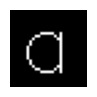

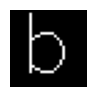

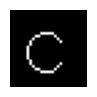

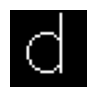

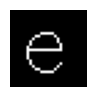

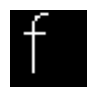

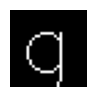

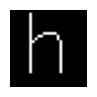

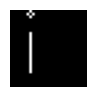

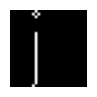

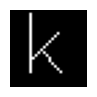

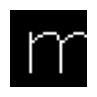

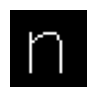

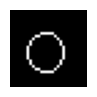

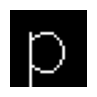

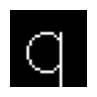

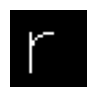

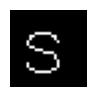

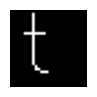

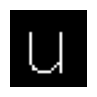

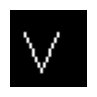

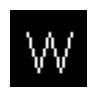

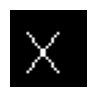

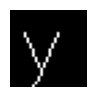

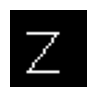

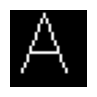

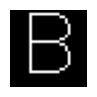

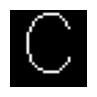

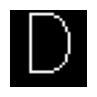

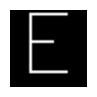

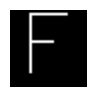

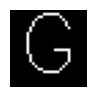

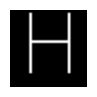

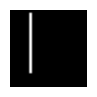

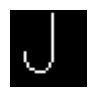

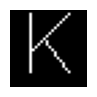

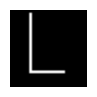

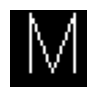

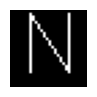

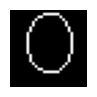

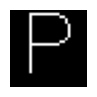

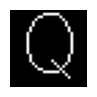

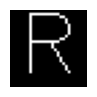

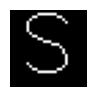

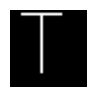

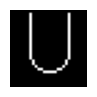

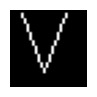

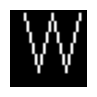

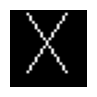

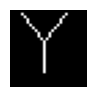

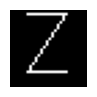

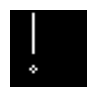

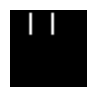

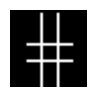

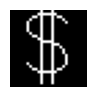

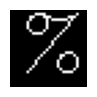

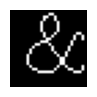

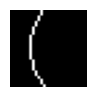

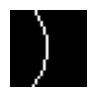

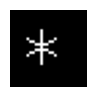

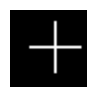

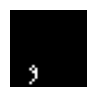

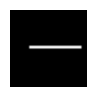

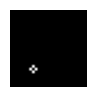

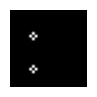

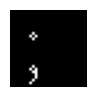

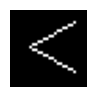

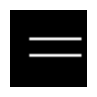

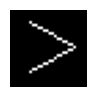

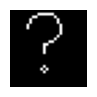

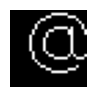

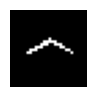

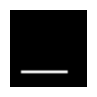

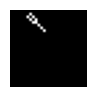

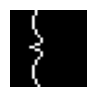

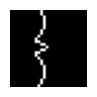

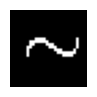

In [259]:
for i, caracterPintable in enumerate(caracteresPintables):
  blackImage = np.zeros((28,28,1), dtype = np.float32)
  # Using cv2.putText() method
  image = cv2.putText(img = blackImage,
    text = caracterPintable,
    org = (3, 22),
    fontFace = cv2.FONT_HERSHEY_SIMPLEX,
    fontScale = 1.0,
    color = (1, 1, 1),
    thickness = 1)
  train_imgs_characters[i] = image
  plt.figure(figsize=(1, 1))
  cv2.imshow("image", image)
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.axis("off");

In [260]:
train_imgs_characters[train_imgs_characters != 0].shape

(3229,)

In [261]:
train_imgs_augmented = np.vstack((train_imgs_augmented, train_imgs_characters))
train_labels_augmented = np.append(train_labels_augmented, train_labels_characters)

In [262]:
print(train_imgs_augmented.shape)
print(train_labels_augmented.shape)

(72077, 28, 28, 1)
(72077,)


In [263]:
num_classes = 11
y_train = keras.utils.to_categorical(train_labels_augmented, num_classes)

In [264]:
val_ratio = 0.1
train_indices, val_indices = train_test_split(
    np.arange(len(train_imgs_augmented)), test_size=val_ratio,
    random_state=42, stratify=train_labels_augmented)

# MODEL

In [265]:
def get_model(num_classes, initial_filters=32, verbose=False):
    model = keras.Sequential(
        [
            keras.Input(shape=train_imgs.shape[1:]),
            layers.Conv2D(initial_filters, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(initial_filters*2, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )

    if verbose:
        model.summary()
        
    return model

In [266]:
model = get_model(num_classes, verbose=False)
# model = get_model(11, verbose=True)
# keras.utils.plot_model(model, show_shapes=True)

# TRAIN

In [287]:
epochs = 100
batch_size = 128

model = get_model(num_classes)
model.compile(loss=CategoricalCrossentropy(label_smoothing=0.1), optimizer="adam", metrics=["accuracy"])

callbacks=[
    keras.callbacks.EarlyStopping(patience=20, monitor='val_accuracy', verbose=True),
    keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, monitor='val_loss', verbose=True)
]

ret = model.fit(train_imgs_augmented[train_indices], y_train[train_indices],
                validation_data=(train_imgs_augmented[val_indices],y_train[val_indices]),
                batch_size=batch_size, epochs=epochs,
                callbacks=callbacks, verbose=1);

Epoch 1/100


2023-09-09 18:20:07.761792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


507/507 [==============================] - ETA: 0s - loss: 0.8308 - accuracy: 0.9074

2023-09-09 18:20:17.645311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


507/507 [==============================] - 11s 20ms/step - loss: 0.8308 - accuracy: 0.9074 - val_loss: 0.6539 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 2/100
507/507 [==============================] - 10s 19ms/step - loss: 0.6605 - accuracy: 0.9745 - val_loss: 0.6243 - val_accuracy: 0.9839 - lr: 0.0010
Epoch 3/100
507/507 [==============================] - 10s 20ms/step - loss: 0.6372 - accuracy: 0.9805 - val_loss: 0.6128 - val_accuracy: 0.9847 - lr: 0.0010
Epoch 4/100
507/507 [==============================] - 10s 19ms/step - loss: 0.6237 - accuracy: 0.9838 - val_loss: 0.6027 - val_accuracy: 0.9874 - lr: 0.0010
Epoch 5/100
507/507 [==============================] - 10s 20ms/step - loss: 0.6148 - accuracy: 0.9859 - val_loss: 0.5962 - val_accuracy: 0.9881 - lr: 0.0010
Epoch 6/100
507/507 [==============================] - 10s 19ms/step - loss: 0.6094 - accuracy: 0.9867 - val_loss: 0.5923 - val_accuracy: 0.9899 - lr: 0.0010
Epoch 7/100
507/507 [==============================] - 10s 20ms/

In [268]:
def plot_train_evolution(ret):
    print()
    for key in ['accuracy', 'val_accuracy']:
        print(f'best {key}: {np.max(ret.history[key]):.3f}')
        values = 1-np.array(ret.history[key])
        label = key.replace('accuracy', 'error') + f' min value {np.min(values):.1e}'
        plt.plot(values, label=label)
    plt.yscale('log')
    plt.title(f'Max val accuracy {np.max(ret.history["val_accuracy"]):.3f}')
    plt.legend(loc=0);
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.grid(which='both')


best accuracy: 0.996
best val_accuracy: 0.995


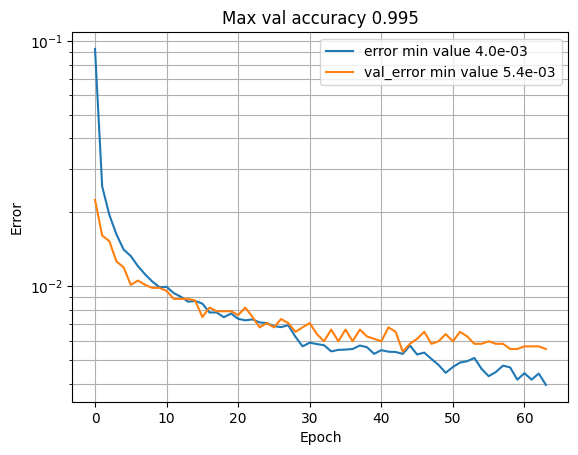

In [288]:
plot_train_evolution(ret)

In [279]:
test_preds = model.predict(test_imgs, batch_size=128, verbose=1)

157/157 [==============================] - 1s 6ms/step


# VISUALIZE

In [271]:
def visualize_test_img_and_pred(idx):
    plt.subplot(121)
    plt.imshow(test_imgs[idx])
    plt.subplot(122)
    #plt.plot(test_preds[idx])
    plt.bar(np.arange(10), test_preds[idx])
    plt.title(f'Max pred {np.max(test_preds[idx]):.2f}')
    plt.ylim(0, 1)
    plt.xticks(np.arange(10))

In [272]:
# for idx in range(10):
#     visualize_test_img_and_pred(idx)
#     plt.show()

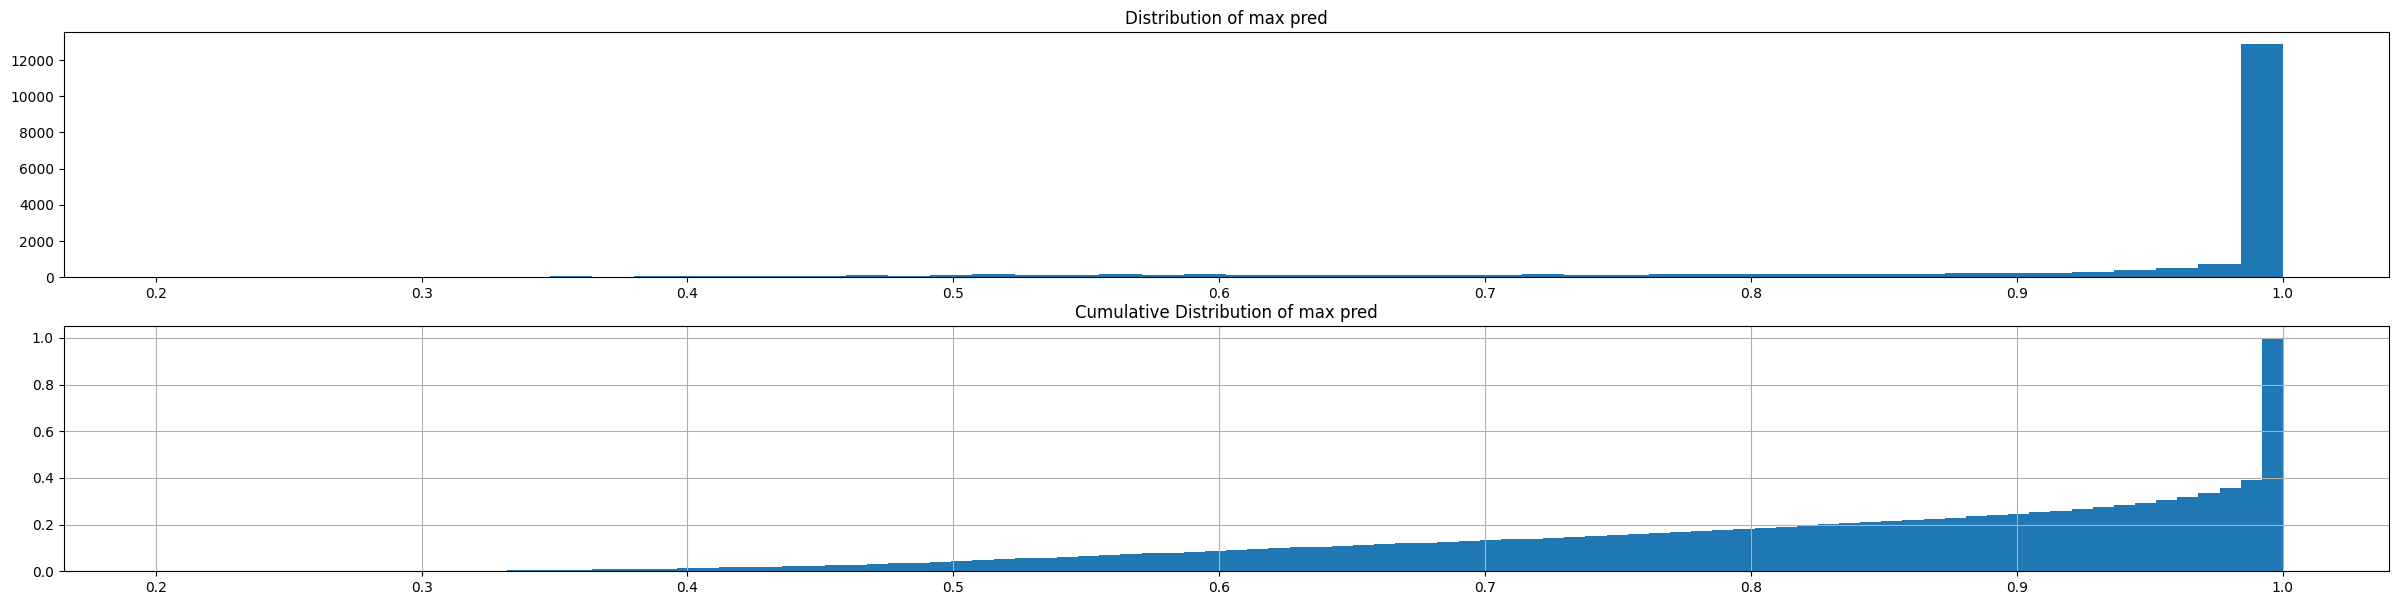

In [273]:
plt.figure(figsize=(30, 7))
max_test_preds = np.max(test_preds, axis=1)
plt.subplot(211)
plt.title('Distribution of max pred')
plt.hist(max_test_preds, bins=50);
plt.subplot(212)
plt.title('Cumulative Distribution of max pred')
plt.hist(max_test_preds, bins=100, cumulative=1, density=True);
plt.grid()

# SUBMIT

In [293]:
test_labels = np.argmax(test_preds, axis=1)
max_test_preds = np.max(test_preds, axis=1)
test_labels[max_test_preds < np.median(max_test_preds)] = 10
nPrediccionesPorClase = np.unique(test_labels, return_counts=True)
display(pd.Series(nPrediccionesPorClase[1]))

0      1165
1       990
2      1038
3       950
4       967
5       972
6       980
7       879
8      1004
9       842
10    10251
dtype: int64

In [294]:
# porcentaje de no numeros predecido
np.round(nPrediccionesPorClase[1][10]*100/test_labels.shape[0],2)

51.16

In [295]:
submission = pd.read_csv(f'{DATASET_FOLDER}/sample_submission.csv')
assert (submission.name == test_names).all()
submission['label'] = test_labels
submission.head()

,name,label
0,000245159744cee166bd566168033e37,10
1,0002fa2768dff946a9440ba527b7094c,0
2,000e6e1550101554e232afc958ad07ca,6
3,0015f3f045a3d501fd0015a3cdd8a918,10
4,0018f902cf6145276b7703b35f77f6e4,10


In [296]:
submission.to_csv('submission.csv', index=False)